In [1]:
!pip install numpy torch torchvision matplotlib gymnasium

In [2]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import random

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch as T

In [3]:
class NaiveCartPoleLinearClassifier(nn.Module):
    def __init__(self, learning_rate, num_classes, input_dimensions):
        super(NaiveCartPoleLinearClassifier, self).__init__()
        
        self.fully_connected_1 = nn.Linear(*input_dimensions, 128)
        self.fully_connected_2 = nn.Linear(128, num_classes)
        
        self.optimizer = optim.Adam(self.parameters(), lr = learning_rate)
        self.loss = nn.MSELoss()
        
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)
        
    def forward(self, data):
        layer1_output = F.relu(self.fully_connected_1(data))
        actions = self.fully_connected_2(layer1_output)
        
        return actions
    
    def learn(self, data, labels):
        self.optimizer.zero_grad()
        data = T.tensor(data).to(self.device)
        labels = T.tensor(labels).to(self.device)
        
        predictions = self.forward(data)
        
        cost = self.loss(prediciton, labels)
        
        cost.backward()
        self.optimizer.step()

In [4]:
class QAgent():
    def __init__(self, learning_rate = 0.0001, discount_factor = 0.99, explore_exploit_start = 1.0, explore_exploit_min = 0.01, decrement = 1e-5, num_actions = 2, num_states = (4, 1)):
        self.q_classifier = NaiveCartPoleLinearClassifier(learning_rate, num_actions, num_states)
        
        self.learning_rate = learning_rate # alpha
        self.discount_factor = discount_factor # gamma
        self.explore_exploit = explore_exploit_start # epsilon
        print(self.explore_exploit)
        self.num_actions = num_actions
        self.explore_exploit_min = explore_exploit_min
        self.ee_decrement = decrement
        
        self.action_space = [i for i in range(self.num_actions)]
        
        
    def choose_action(self, current_state):
        random_number = np.random.random()
        if random_number < self.explore_exploit:
            return np.random.choice(self.action_space)
        else:
            return T.argmax(self.q_classifier.forward(T.tensor(current_state, dtype=T.float).to(self.q_classifier.device))).item()
            
    def decrement_explore_exploit(self):
        prev_value = self.explore_exploit
        new_value = (self.explore_exploit - self.ee_decrement) if self.explore_exploit > self.explore_exploit_min else self.explore_exploit_min
        self.explore_exploit = new_value
        #print(f"decrement_explore_exploit prev_value: {prev_value} new_value: {new_value} explore_exploit: {self.explore_exploit} ")
        
    def learn(self, current_state, action, reward, new_state):
        #self.q_table[current_state][action] +=  (reward + self.discount_factor * np.max(self.q_classifier(new_state)) - self.q_classifier(current_state)[action])
        self.q_classifier.optimizer.zero_grad()
        current_states = T.tensor(current_state, dtype = T.float).to(self.q_classifier.device)
        actions = T.tensor(action).to(self.q_classifier.device)
        rewards = T.tensor(reward).to(self.q_classifier.device)
        new_states = T.tensor(new_state, dtype = T.float).to(self.q_classifier.device)
        
        predictions = self.q_classifier.forward(current_states)[actions]
        
        next_predictions = self.q_classifier.forward(new_states).max()
        
        next_target = reward + self.discount_factor * next_predictions 
        
        cost = self.q_classifier.loss(next_target, predictions).to(self.q_classifier.device)
        
        cost.backward()
        
        self.q_classifier.optimizer.step()
        
        self.decrement_explore_exploit()
        
    
                
        

In [5]:
#agent = QAgent()

In [6]:
env = gym.make('CartPole-v1')
env.reset()

(array([-1.5324063e-02, -4.5995586e-02, -4.3624777e-02,  3.7905374e-05],
       dtype=float32),
 {})

In [14]:
def plot_learning_curve(x, scores, epsilons, filename):
    figure = plt.figure()
    ax = figure.add_subplot(111, label = "1")
    ax2 = figure.add_subplot(111, label = "2", frame_on = False)
    
    ax.plot(x, epsilons, color = "C0")
    ax.set_xlabel("Training Steps", color = "C0")
    ax.set_ylabel("Epsilon", color = "C0")
    ax.tick_params(axis = "x", colors = "C0")
    ax.tick_params(axis = "y", colors = "C0")
    
    N = len(scores)
    running_average = np.empty(N)
    for t in range(N):
        running_average[t] = np.mean(scores[max(0, t - 100):(t + 1)])
        
    ax2.scatter(x, running_average, color = "C1")
    ax2.axes.get_xaxis().set_visible(False)
    ax2.yaxis.tick_right()
    ax2.set_ylabel("Score", color = "C1")
    ax2.yaxis.set_label_position("right")
    ax2.tick_params(axis = "y", colors = "C1")
    
    plt.savefig(filename)
    

In [8]:
action = None
# 1000 Games
game_results = []
win_percentages = []
epsilon_history = []
number_games = 10000

agent = QAgent(num_states = env.observation_space.shape, num_actions = env.action_space.n)

for i in range(number_games):
    terminated = False
    truncated = False
    observation, info = env.reset()
    score = 0
    while not terminated and not truncated:
        action = agent.choose_action(observation)
        observation_, reward, terminated, truncated, info = env.step(action)
        
        agent.learn(observation, action, reward, observation_)
        score += reward
        observation = observation_
    
    game_results.append(score)
    epsilon_history.append(agent.explore_exploit)
    
    if i % 100 == 0:
        win_percentages.append(np.mean(game_results[-100:]))
        #if i % 1000 == 0:
        print(f'Episode: {i} Win Percent: {win_percentages[-1]:.3f} Epsilon: {agent.explore_exploit:.2f}') 
     
print(f'Number: {len(game_results)} Sum: {sum(game_results)}')
plt.plot(win_percentages)
plt.show()

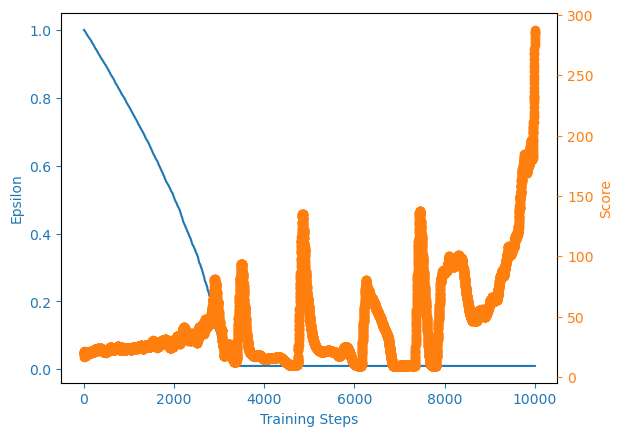

In [15]:
filename = 'cartpole_naive_dqn.png'
x = [i + 1 for i in range(number_games)]
plot_learning_curve(x, game_results, epsilon_history, filename)